# Leaf Shape Classification Using Histogram of Curvature Scale (HoCS)

This notebook implements a classical shape-based computer vision pipeline for classifying leaf silhouettes using the **Histogram of Curvature Scale (HoCS)** descriptor.  

The approach extracts multi-scale curvature information from object boundaries and uses a **K-Nearest Neighbours (KNN)** classifier to distinguish between leaf shape classes.

The focus is on:
- Boundary-based shape descriptors
- Multi-scale curvature analysis
- Feature normalization and distance-based classification
- Error analysis using confusion matrices


## Histogram of Curvature Scale Descriptor

The Histogram of Curvature Scale (HoCS) descriptor captures boundary curvature information across multiple spatial scales.  
At each scale, curvature is computed using the **normalized area integral invariant**, which measures the proportion of foreground pixels within a circular neighborhood centered at boundary points.

For each scale:
- Curvature values are sampled along the object boundary
- A histogram of curvature responses is constructed
- Histograms are normalized and concatenated across scales

The resulting feature vector provides a compact, multi-scale description of object shape while remaining robust to small boundary perturbations.


In [ ]:
import skimage.io as io
import skimage.util as util
import skimage.segmentation as seg
import matplotlib.pyplot as plt
import skimage.morphology as morph
import scipy.ndimage as ndi
import numpy as np


def HoCS(B, min_scale, max_scale, increment, num_bins):
    '''
    Computes a histogram of curvature scale for the shape in the binary image B.  
    Boundary fragments due to holes are ignored.
    :param B: A binary image consisting of a single foreground connected component.
    :param min_scale: smallest scale to consider (minimum 1)
    :param max_scale: largest scale to consider (max_scale > min_scale)
    :param increment:  increment on which to compute scales between min_scale and max_scale
    :param num_bins: number of bins for the histogram at each scale
    :return: 1D array of histograms concatenated together in order of increasing scale.
    '''

    ## calculate normalized area integreal invariant at multiple scales

    B = util.img_as_float64(B)
    b = seg.find_boundaries(B,connectivity=1, mode="inner")  #b is boundary img of B


    histograms = []
    for radius in range (min_scale,max_scale+1,increment):
        circle = morph.disk(radius)

        intersectionforwholeimg = ndi.convolve(B,circle)
        norm = intersectionforwholeimg / np.sum(circle)
        curve = norm[b]

        hist, _ = np.histogram(curve,bins=num_bins, range=(0,1))
        hist = hist/np.sum(hist)
        histograms.append(hist)

    #concat hissts:
    hocs = np.concatenate(histograms)
    
    hocs = hocs/ np.linalg.norm(hocs)  #  l2norm vector

    return hocs





# img = io.imread("./leaftraining/leaftraining/image_0001.png")
# # plt.figure()
# # plt.imshow(img,cmap='gray')
# hocs = HoCS(img,4,20,3,16)
# plt.figure()
# #plt.show(x)
# plt.plot(hocs)
# #print(x.shape)

    

## Descriptor Visualization

To verify the behavior of the HoCS descriptor, the feature vector is computed for a single leaf image and visualized as a bar plot.  
This helps confirm that curvature responses are well-distributed across scales and histogram bins.


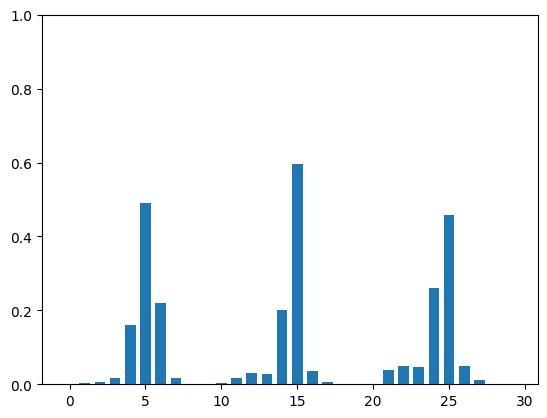

In [ ]:
import skimage.io as io
%matplotlib inline


img = io.imread("./leaftraining/leaftraining/image_0001.png")
hocs= HoCS(img , 5, 25, 10,10)
plt.bar(range(len(hocs)), hocs, width=0.7)
plt.ylim(0.0, 1.0)
plt.show()

## Feature Extraction for Training Data

HoCS feature vectors are computed for all training images using a fixed set of parameters.  
Class labels are assigned based on dataset ordering, with each image represented by a single concatenated HoCS descriptor.


In [ ]:
import os as os
import pandas as pd

# read in the images listed in leaftraining.csv and compute descriptors for them


# 0 to 9  === class 1
# 10 to 19 === class 2
# 20 === 39 === class 3


hocsList=[]
hocsClass=[]

training_path = './leaftraining/leaftraining/'

files = pd.read_csv('./leaftraining/leaftraining.csv', header=None)[0].tolist()


for i, filename in enumerate(files):
    if not filename.endswith('.png'):
        continue

    img = io.imread(os.path.join(training_path, filename))
    hocs = HoCS(img, min_scale=4, max_scale=27,increment=3, num_bins=16)
    hocsList.append(hocs)

    if i <10:
        label = 1
    elif i <20:
        label = 2
    else:
        label=3

    hocsClass.append(label)









## K-Nearest Neighbours Classifier
A knn classifier is trained using the extracted HoCS feature vectors.  
KNN is well-suited for this task due to its simplicity and effectiveness when paired with meaningful distance-based descriptors.

In [ ]:
import sklearn.neighbors as neigh

#tain knn
knn = neigh.KNeighborsClassifier(n_neighbors=7)
knn.fit(hocsList,hocsClass)


,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## Feature Extraction for Test Data
HoCS features are computed for the test dataset using the same parameters as the training set to ensure consistency.  
These features are then used for evaluating classifier performance.


In [ ]:

testing_path = './leaftesting/leaftesting/'
files = pd.read_csv('./leaftesting/leaftesting.csv', header=None)[0].tolist()


testList=[]
testClass =[]
for i, filename in enumerate(files):
    if not filename.endswith('.png'):
        continue
    img = io.imread(os.path.join(testing_path, filename))
    hocs = HoCS(img, min_scale=4, max_scale=27,increment=3, num_bins=16)
    testList.append(hocs)
    
    if i<50:
        label = 1
    elif i < 77:
        label =2
    else:
        label=3

    testClass.append(label)

X_test = np.array(testList)
y_test = np.array(testClass)

print("Test features:", X_test.shape)
print("Test labels:", y_test.shape)


Test features: (129, 128)
Test labels: (129,)


## Classification Results and Evaluation

The trained KNN classifier is applied to the test feature vectors.  
Performance is evaluated using:
- Overall classification accuracy
- A confusion matrix
- Inspection of any misclassified samples

In [ ]:
import sklearn.metrics as met


# we have the actual labels for the test images in step 5, now we see if knn can predict labels correctly
preds= knn.predict(X_test)

# ytrue, ypred
cm = met.confusion_matrix(y_test, preds, labels=[1,2,3])

accuracy = np.mean(preds == y_test)
print("Confusion Matrix:")
print(cm)

print("")
print("Incorrectly classified images:")
for i in range(len(y_test)):
    if preds[i] != y_test[i]:
        print(files[i], "::: predicted:", preds[i], "expected:", y_test[i])
print("")

print("Correct Classificaiton Rate: "+str(accuracy*100) + "%")





Confusion Matrix:
[[49  0  1]
 [ 0 27  0]
 [ 1  1 50]]

Incorrectly classified images:
image_0060.png ::: predicted: 3 expected: 1
image_0153.png ::: predicted: 1 expected: 3
image_0185.png ::: predicted: 2 expected: 3

Correct Classificaiton Rate: 97.67441860465115%


## Review: Parameter Selection and Error Analysis

### HoCS Parameter Selection

The HoCS parameters were chosen to balance sensitivity to fine-scale curvature detail and robustness to boundary noise.  
Scales ranging from 4 to 27 capture both local curvature variations and global shape structure, while an increment of 3 provides sufficient resolution without excessive feature dimensionality.

Using smaller minimum scales increased sensitivity to noise and minor boundary irregularities, which reduced class separability.  
Sixteen histogram bins provided a stable distribution of curvature values without introducing sparsity.

### KNN Hyperparameter Choice

A value of k = 7 was selected for the KNN classifier.  
Smaller values of k were overly sensitive to outliers, while larger values led to underfitting by smoothing class boundaries.  
Values of 6 and 7 produced similar results, with k = 7 yielding slightly more stable performance.

### Misclassification Analysis

Three test images were misclassified.  
Confusion occurred primarily between classes with similar global curvature characteristics, where boundary shapes lie close to class decision boundaries in feature space.  
These cases highlight the limitations of purely shape-based descriptors when inter-class morphological differences are subtle.
